In this session you will:

- learn how to implement the Pagerank algorithm to determine the relative importance of webpages
- apply it to a large graph of links between Wikipedia articles

## 1. Pagerank on a toy graph

### Install fast graph analysis package (`igraph`)

In [1]:
!pip3 install igraph --user

In [3]:
import numpy as np

### Create and visualize a toy graph

4 vertices, 8 edges


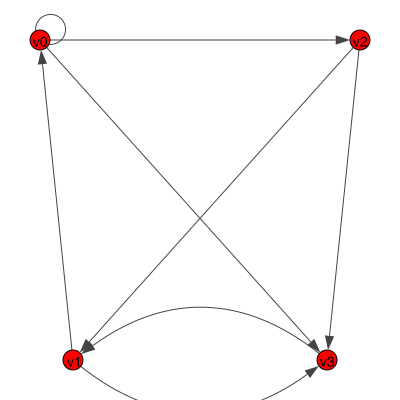

In [6]:
from igraph import Graph, plot

def example_graph(edges):
    n = max(map(max, zip(*edges))) + 1
    vertex_names = ["v%i" % i for i in range(n)]
    print("%i vertices, %i edges" % (n, len(edges)))
    return vertex_names, edges

def to_igraph(vertex_names, edges):
    G = Graph(n=len(vertex_names), directed=True)
    G.add_edges(edges)
    G.vs["name"] = vertex_names
    return G

names, edges = example_graph([ (0, 0), (0, 2), (0, 3), (1, 0), (1, 3), (2, 1), (2, 3), (3, 1)])
G = to_igraph(names, edges)
plot(G, layout="fr", vertex_label=names, bbox=(400,400), margin=40)

### Display adjacency and transition matrices

In [7]:
import numpy as np

def adjacency_matrix(edges, n):
    src, dest = zip(*edges)
    A = np.zeros((n, n))
    A[src, dest] = 1
    return A

# Compute transition matrix (row-stochastic): 
#    M[i, j] = probability of going from i to j in one step
# Note the result is undefined if there are nodes of out-degree 0, but these do not occur in our example
def transition_matrix(A):
    row_sums = A.sum(axis=1, keepdims=True)           # keepdims=True keeps the result as a column vector
    return A / row_sums
    
print("Adjacency matrix")
A = adjacency_matrix(edges, len(names))
print(A)

M = transition_matrix(A)
print("\nTransition matrix (row-normalized):")
print(M)

Adjacency matrix
[[1. 0. 1. 1.]
 [1. 0. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]]

Transition matrix (row-normalized):
[[0.33333333 0.         0.33333333 0.33333333]
 [0.5        0.         0.         0.5       ]
 [0.         0.5        0.         0.5       ]
 [0.         1.         0.         0.        ]]


### Compute Pagerank vector and check that it satisfies the Pagerank linear equations

Recall that Pagerank is a solution to the recursive equation "a node is important iff it is pointed to by other important nodes". Each node distributes its "importance" (pagerank) equally among its outgoing neighbors. Thus, if $p$ is the Pagerank vector, $p_i$ should coincide with the importance received by node $i$, i.e., the $i$th row of $M^T \cdot p$. 

In [8]:
pr = G.pagerank(damping=1)
print("Nodes by decreasing pagerank:")
for (p, name) in reversed(sorted(zip(pr, names))):
    print("%s: %lf" % (name, p))
    
print("\nsum(v) =", sum(pr))
print("Mᵀ · v =", M.T.dot(pr))
print("v =", pr)

# Note that we need to allow some tolerance when comparing floating-point values
print("max error =", np.abs(M.T.dot(pr) - pr).max())
assert np.allclose(M.T.dot(pr), pr)

Nodes by decreasing pagerank:
v1: 0.347826
v3: 0.304348
v0: 0.260870
v2: 0.086957

sum(v) = 1.0
Mᵀ · v = [0.26086957 0.34782609 0.08695652 0.30434783]
v = [0.2608695652173913, 0.34782608695652173, 0.08695652173913043, 0.30434782608695654]
max error = 0.0


/Users/davidmorais/.local/lib/python3.10/site-packages/igraph/structural.py:74: RuntimeWarning: Damping factor is 1. Damping values close to 1 may lead to numerical instability when using PRPACK. Location: src/centrality/prpack.cpp:87
  return graph.personalized_pagerank(


### Alternatively, compute pagerank from eigenvector calculations (for didactic purposes)


In [ ]:
# The pagerank vector as the eigenvector of M.T associated to eigenvalue 1
def eig_pagerank(M):
    vals, vecs = np.linalg.eig(M.T)
    idx = np.argmin(np.abs(vals - 1))              # eigenvalue closest to 1; it should actually be 1    
    r = np.real(vecs[:, idx])    
    return r / r.sum()

r = eig_pagerank(M)
print("PageRank vector:", r)
print("max error with previously computed pagerank =", np.abs(r - pr).max())

PageRank vector: [0.26086957 0.34782609 0.08695652 0.30434783]
max error with previously computed pagerank = 2.7755575615628914e-16


---

**Exercise 1:**  
Make sure you understand the code above. Now write a third way to compute the Pagerank by exploiting the random-surfer viewpoint of Pagerank. The idea is to compute the probability distribution of the surfer's location among all nodes in the graph after a large enough number of steps. Explain what interpretation the transpose of the matrix $M$ has in this setting, why we need to consider the transpose and why normalizing the adjacency matrix is necessary. 

Your function should take the matrix $M$, a number of steps $T$, and a column vector $v$ describing the initial probability distribution. For example, starting at a random node is represented by the vector `np.array([1, 1, 1, 1]) / 4` (if there are 4 nodes). Check that you still get the same pagerank vector as before.

Hint: ```np.linalg.matrix_power()```, ```np.ones()``` and/or ```np.zeros()``` might come in handy.

In [10]:
def random_surfer_pagerank(M, T, v):
    return np.linalg.matrix_power(M.T, T).dot(v)

In [11]:
# Probar con distribución inicial uniforme
v_init = np.ones(len(names)) / len(names)
pr_surfer = random_surfer_pagerank(M, 100, v_init)
print("Random surfer PageRank:", pr_surfer)
print("Max error with igraph:", np.abs(pr_surfer - pr).max())

Random surfer PageRank: [0.26086957 0.34782609 0.08695652 0.30434783]
Max error with igraph: 5.551115123125783e-17


---

**Exercise 2:**  
In class we saw how introducing a damping factor $\lambda\in(0,1)$ allows us to ignore corner cases such as aperiodicity and lack of strong connectivity.
Modify your function from Exercise 1, as well as the eigenvalue-based solution, to incorporate a damping parameter and check that both still give the same result as `G.pagerank(damping=...)` from `igraph`.

## 2. Pagerank on Wikipedia

Now we will write our own implementation of Pagerank (with a damping factor) on a real-world graph with a hundred million edges, built from hyperlinks in Wikipedia articles:

https://snap.stanford.edu/data/enwiki-2013.html

### Download and decompress dataset from the Stanford Network Analysis Project

In [14]:
!wget https://snap.stanford.edu/data/enwiki-2013.txt.gz && gunzip enwiki-2013.txt.gz
!wget https://snap.stanford.edu/data/enwiki-2013-names.csv.gz && gunzip enwiki-2013-names.csv.gz

--2025-11-11 17:49:38--  https://snap.stanford.edu/data/enwiki-2013.txt.gz
Resolviendo snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Conectando con snap.stanford.edu (snap.stanford.edu)[171.64.75.80]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 335102744 (320M) [application/x-gzip]
Grabando a: «enwiki-2013.txt.gz»

enwiki-2013.txt.gz  100%[===================>] 319,58M  11,3MB/s    en 30s     

2025-11-11 17:50:09 (10,5 MB/s) - «enwiki-2013.txt.gz» guardado [335102744/335102744]

--2025-11-11 17:50:14--  https://snap.stanford.edu/data/enwiki-2013-names.csv.gz
Resolviendo snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Conectando con snap.stanford.edu (snap.stanford.edu)[171.64.75.80]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 44666496 (43M) [application/x-gzip]
Grabando a: «enwiki-2013-names.csv.gz»

enwiki-2013-names.c 100%[===================>]  42,60M  7,14MB/s    en 11s     

2025-11-11 17:50:26

In [15]:
import pandas as pd

# Load directed edges as (src, dest) pairs. Vertices are numbered from 0 to (number of vertices) - 1, inclusive.
src, dest = np.loadtxt('enwiki-2013.txt', comments='#', dtype=np.int32).T
edges = np.column_stack((src, dest))

# Load webpage titles
titles = pd.read_csv("enwiki-2013-names.csv", escapechar='\\', dtype={"node_id": "int32", "name": "string"})
titles = titles["name"].fillna("").to_numpy()           # replace missing titles with an empty string

n = max(len(titles), np.max(src) + 1, np.max(dest) + 1)
m = len(src)
print("Loaded graph: %i vertices, %i directed edges" % (n, m))

Loaded graph: 4206785 vertices, 101311613 directed edges


In [16]:
# Create the sparse adjacency matrix A: A[src[i]][dest[i]] = 1 for all i in [m] and 0 elsewhere
# This is internally represented as an adjacency list mapping each vertex to its outgoing neighbors.
# So the space usage is O(m), rather than Omega(n^2), which would be impractical
from scipy import sparse
A = sparse.csr_matrix((np.ones_like(src, dtype=np.float32), (src, dest)), shape=(n, n), dtype=np.float32)

In [17]:
# Note that some nodes have out-degree 0. You need to decide how to handle them.
outdeg = np.asarray(A.sum(axis=1)).ravel()
sinks = np.where(outdeg == 0)[0]
print("%i dead-end nodes" % len(sinks))

7891 dead-end nodes


### Cheating by using libraries

#### You may use igraph it to verify the correctness of your code, once it has been implemented

In [ ]:
%%time
G = to_igraph(titles, edges)
pr_lib = G.pagerank(damping=0.8)

CPU times: user 1min 32s, sys: 4.99 s, total: 1min 37s
Wall time: 43 s


In [ ]:
import heapq

def show_topk(pr, titles, topk=20):
    print("Top %i nodes in order of decreasing pagerank:" % topk)
    for p, name in heapq.nlargest(topk, zip(pr, titles), key=lambda x: x[0]):
        print("%s: %lf" % (name, p))
        
show_topk(pr_lib, titles, 20)                

Top 20 nodes in order of decreasing pagerank:
United States: 0.002892
France: 0.001175
United Kingdom: 0.001075
Germany: 0.001056
List of sovereign states: 0.000919
Animal: 0.000893
England: 0.000884
Canada: 0.000880
Association football: 0.000870
World War II: 0.000836
India: 0.000825
Australia: 0.000706
Italy: 0.000662
Japan: 0.000651
English language: 0.000618
China: 0.000580
London: 0.000544
Russia: 0.000517
Poland: 0.000509
Spain: 0.000489


### Our problem

---

**Exercise 3:**  
Write an efficient implementation of Pagerank with a damping factor < 1 and compare with `igraph`'s implementation in terms of accuracy (e.g., difference in pagerank vectors, top $k$ overlap, etc.) and running time. You may use `numpy`, `scipy` and/or similar libraries for matrix operations if you wish, but no graph libraries are allowed.

It is essential to make use of the sparsity of this graph, so you will need to design an efficient solution in time and space usage. In particular, our earlier solution computing powers of $M^T$ cannot be used directly, because the powers of $M^T$ will be very dense.

Think about how we can implement a random step of the surfer efficiently, assuming we know the probability distribution of the surfer's location in the graph at the previous step. A single step corresponds to a multiplication between the matrix $M^T$ from above and the current pagerank vector, along with a correction to account for teleportation.

As a (relatively minor) implementation detail, you also need to decide on simple strategies to
- handle nodes with out-degree zero, and
- decide when to stop iterating.

---
**Exercise 4 (personalized Pagerank):**
Modify your solution from Exercise 3 to accept a teleportation set as input. Compute Pagerank again, but with teleportation reduced to the set of articles whose title contains the word "tennis". 

How do the results change and why? Can you find a top tennis-related article that is not in the teleportation set? If we decreased the damping parameter, would you expect to find more or fewer tennis-related articles among the top results?